#  ***Import Necessary Libraries***

In [ ]:
# Importing necessary libraries
import numpy as np        # For numerical operations
import pandas as pd       # For data manipulation and analysis
import matplotlib.pyplot as plt  # For data visualization
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
import re
import string
# Importing NLTK for natural language processing
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords    # For stopwords
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer # for Tokenize the text
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Downloading NLTK data
nltk.download('stopwords')   # Downloading stopwords data

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True


# ***1. Loading Data 💎***

---



---



In [ ]:
#Defining all our palette colours
primary_blue = "#496595"
primary_blue2 = "#85a1c1"
primary_blue3 = "#3f4d63"
primary_grey = "#c6ccd8"
primary_black = "#202022"
primary_bgcolor = "#f4f0ea"

primary_green = px.colors.qualitative.Plotly[2]

### ***Load the data***

In [ ]:
from google.colab import driveS
drive.mount("/content/drive")
df = pd.read_csv('/content/drive/MyDrive/PFE/spam.csv', encoding='latin1')
df.head()

Mounted at /content/drive


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [ ]:
df.drop(columns = ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace = True)

In [ ]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
 # Rename the columns name
df.rename(columns = {'v1': 'target', 'v2': 'message'}, inplace = True)

In [ ]:
df['message_len'] = df['message'].apply(lambda x: len(x.split(' ')))
df.head()

,target,message,message_len
0,ham,"Go until jurong point, crazy.. Available only ...",20
1,ham,Ok lar... Joking wif u oni...,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28
3,ham,U dun say so early hor... U c already then say...,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",13


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   target       5572 non-null   object
 1   message      5572 non-null   object
 2   message_len  5572 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 130.7+ KB


In [ ]:
max(df['message_len'])

171

#  ***2. EDA 📊***

* Exploratory Data Analysis (EDA) helps in understanding the dataset, visualizing the distribution of data, and identifying any anomalies.

In [ ]:
balance_counts = df.groupby('target')['target'].agg('count').values
balance_counts

array([4825,  747])

In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['ham'],
    y=[balance_counts[0]],
    name='ham',
    text=[balance_counts[0]],
    textposition='auto',
    marker_color=primary_blue
))
fig.add_trace(go.Bar(
    x=['spam'],
    y=[balance_counts[1]],
    name='spam',
    text=[balance_counts[1]],
    textposition='auto',
    marker_color=primary_grey
))
fig.update_layout(
    title='<span style="font-size:32px; font-family:Times New Roman">Dataset distribution by target</span>'
)
fig.show()

As we can see, the classes are imbalanced, so we can consider using some kind of resampling. We will study later. Anyway, it doesn't seem to be necessary.

In [ ]:
ham_df = df[df['target'] == 'ham']['message_len'].value_counts().sort_index()
spam_df = df[df['target'] == 'spam']['message_len'].value_counts().sort_index()

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=ham_df.index,
    y=ham_df.values,
    name='ham',
    fill='tozeroy',
    marker_color=primary_blue,
))
fig.add_trace(go.Scatter(
    x=spam_df.index,
    y=spam_df.values,
    name='spam',
    fill='tozeroy',
    marker_color=primary_grey,
))
fig.update_layout(
    title='<span style="font-size:32px; font-family:Times New Roman">Data Roles in Different Fields</span>'
)
fig.update_xaxes(range=[0, 70])
fig.show()

As we can see, the ham message length tend to be lower than spam message length.

# ***3. Data Pre-processing 🛠***

Now we are going to engineering the data to make it easier for the model to clasiffy.

This section is very important to reduce the dimensions of the problem.

## ***3.1 Cleaning the corpus 🛠***

In [ ]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [ ]:
df['message_clean'] = df['message'].apply(clean_text)
df.head()

,target,message,message_len,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go until jurong point crazy available only in ...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry in a wkly comp to win fa cup final...
3,ham,U dun say so early hor... U c already then say...,11,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah i dont think he goes to usf he lives aroun...


***Stopwords***

Stopwords are commonly used words in English which have no contextual meaning in an sentence. So therefore we remove them before classification. Some examples removing stopwords are:

In [ ]:
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

df['message_clean'] = df['message_clean'].apply(remove_stopwords)
df.head()

,target,message,message_len,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry wkly comp win fa cup final tkts m...
3,ham,U dun say so early hor... U c already then say...,11,dun say early hor already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goes usf lives around though


## ***3.2 Stemming 🛠***

***Stemming/ Lematization***

For grammatical reasons, documents are going to use different forms of a word, such as write, writing and writes. Additionally, there are families of derivationally related words with similar meanings. The goal of both stemming and lemmatization is to reduce inflectional forms and sometimes derivationally related forms of a word to a common base form.

***Stemming*** usually refers to a process that chops off the ends of words in the hope of achieving goal correctly most of the time and often includes the removal of derivational affixes.

***Lemmatization*** usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base and dictionary form of a word


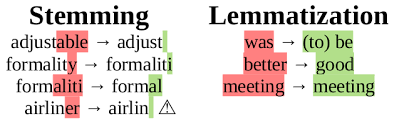

### ***Stemming algorithms***

There are several stemming algorithms implemented in NLTK Python library:

***1. PorterStemmer*** uses Suffix Stripping to produce stems. PorterStemmer is known for its simplicity and speed. Notice how the PorterStemmer is giving the root (stem) of the word "cats" by simply removing the 's' after cat. This is a suffix added to cat to make it plural. But if you look at 'trouble', 'troubling' and 'troubled' they are stemmed to 'trouble' because PorterStemmer algorithm does not follow linguistics rather a set of 05 rules for different cases that are applied in phases (step by step) to generate stems. This is the reason why PorterStemmer does not often generate stems that are actual English words. It does not keep a lookup table for actual stems of the word but applies algorithmic rules to generate stems. It uses the rules to decide whether it is wise to strip a suffix.
2. One can generate its own set of rules for any language that is why Python nltk introduced ***SnowballStemmers*** that are used to create non-English Stemmers!
***3. LancasterStemmer*** (Paice-Husk stemmer) is an iterative algorithm with rules saved externally. One table containing about 120 rules indexed by the last letter of a suffix. On each iteration, it tries to find an applicable rule by the last character of the word. Each rule specifies either a deletion or replacement of an ending. If there is no such rule, it terminates. It also terminates if a word starts with a vowel and there are only two letters left or if a word starts with a consonant and there are only three characters left. Otherwise, the rule is applied, and the process repeats.

In [ ]:
stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text
df['message_clean'] = df['message_clean'].apply(stemm_text)
df.head()

,target,message,message_len,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joke wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entri wkli comp win fa cup final tkts m...
3,ham,U dun say so early hor... U c already then say...,11,dun say earli hor alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goe usf live around though


## ***3.3 All together 🛠***

* this function is a combination of the preprocessing steps we've previously defined. It cleans the text by removing punctuation, URLs, and other unwanted elements, removes stopwords, and then stems the remaining words.

In [ ]:
def preprocess_data(text):
    # Clean puntuation, urls, and so on
    text = clean_text(text)
    # Remove stopwords
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    # Stemm all the words in the sentence
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))

    return text

In [ ]:
df['message_clean'] = df['message_clean'].apply(preprocess_data)
df.head()

,target,message,message_len,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joke wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entri wkli comp win fa cup final tkts m...
3,ham,U dun say so early hor... U c already then say...,11,dun say ear hor alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goe usf live around though


## ***3.4 Target encoding 🛠***

* Let's encode the target variable 'target' into numerical labels and stores the encoded labels in a new column 'target_encoded'

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(df['target'])

df['target_encoded'] = le.transform(df['target'])
df.head()

,target,message,message_len,message_clean,target_encoded
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazi avail bugi n great world...,0
1,ham,Ok lar... Joking wif u oni...,6,ok lar joke wif oni,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entri wkli comp win fa cup final tkts m...,1
3,ham,U dun say so early hor... U c already then say...,11,dun say ear hor alreadi say,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goe usf live around though,0


# ***4. Tokens visualization 📊***


* To visualize tokens in text data, we can use various techniques such as word clouds, bar charts, or histograms.
Here's a bar chart to visualize the most common tokens (words) in our preprocessed text data:

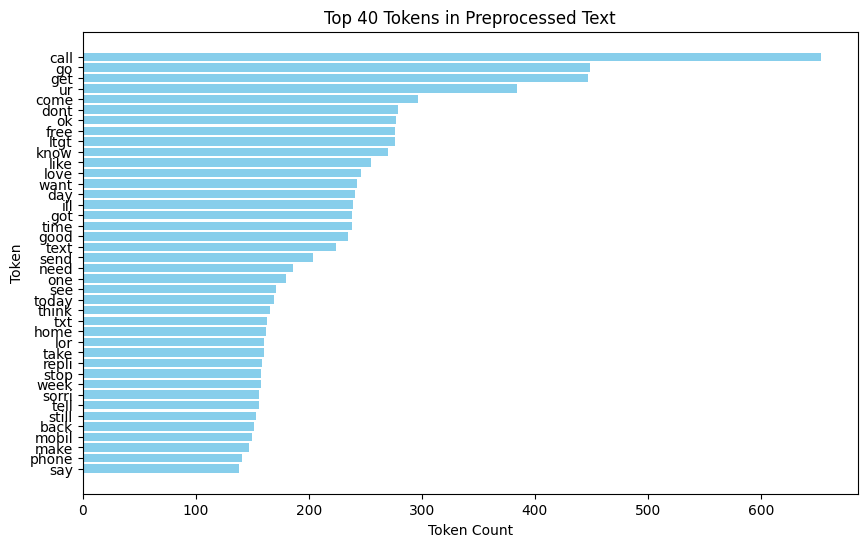

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Create a CountVectorizer instance
vectorizer = CountVectorizer()

# Fit the vectorizer to our preprocessed text data
X = vectorizer.fit_transform(df['message_clean'])

# Récupère les noms des tokens utilisés pour représenter les données
feature_names = vectorizer.get_feature_names_out()

# Calcule le nombre total d'occurrences de chaque token
token_counts = X.sum(axis=0).A1

# Create a dictionary mapping tokens to their counts
token_count_dict = dict(zip(feature_names, token_counts))

# Sort the dictionary by counts in descending order
sorted_token_count_dict = dict(sorted(token_count_dict.items(), key=lambda item: item[1], reverse=True))

# Get the top n tokens and their counts
n = 40
top_tokens = list(sorted_token_count_dict.keys())[:n]
top_token_counts = list(sorted_token_count_dict.values())[:n]

# Plot the top n tokens and their counts
plt.figure(figsize=(10, 6))
plt.barh(top_tokens, top_token_counts, color='skyblue')
plt.xlabel('Token Count')
plt.ylabel('Token')
plt.title('Top {} Tokens in Preprocessed Text'.format(n))
plt.gca().invert_yaxis()  # Invert y-axis to display the most frequent tokens at the top
plt.show()

* Top words for HAM and SPAM messages

In [ ]:
!pip install wordcloud

In [ ]:
from wordcloud import WordCloud


# Separate spam and ham messages
spam_messages = df[df['target'] == 'spam']['message_clean']
ham_messages = df[df['target'] == 'ham']['message_clean']

# Generate word cloud for ham messages
spam_text = ' '.join(spam_messages)
spam_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(spam_text)
# Generate word cloud for ham messages
ham_text = ' '.join(ham_messages)
ham_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(ham_text)


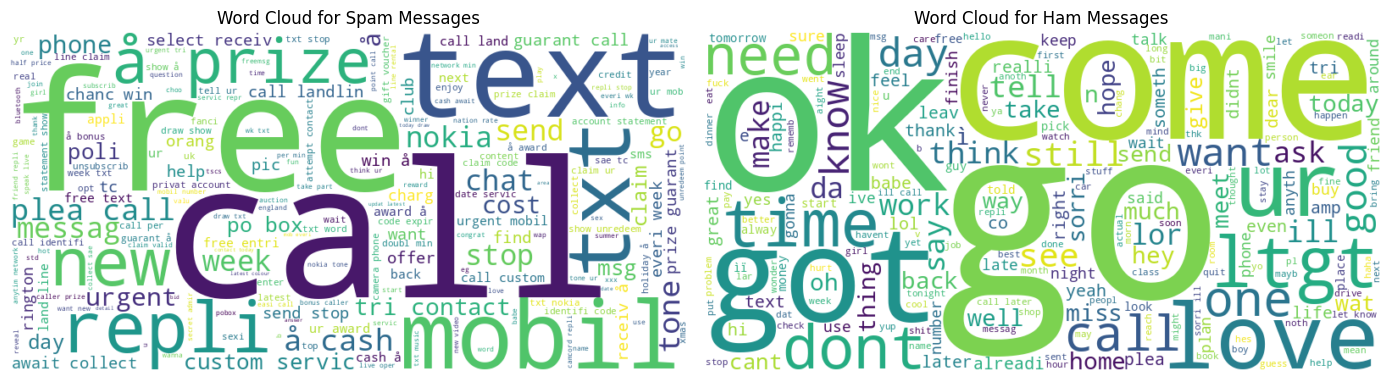

In [ ]:
# Plot word clouds
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Spam Messages')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Ham Messages')
plt.axis('off')

plt.tight_layout()
plt.show()

# ***5. Vectorization***

* vectorization is a critical preprocessing step that transforms textual data into a format suitable for deep learning models. It enables the models to learn meaningful patterns and relationships from the text data, ultimately improving the accuracy of spam email detection

### ***Vectorization Techniques:***

---


* ***Count Vectorization:*** This technique represents each document (email) as a vector where each dimension corresponds to a unique word in the corpus, and the value of each dimension represents the count of that word in the document.

* ***TF-IDF Vectorization:*** TF-IDF (Term Frequency-Inverse Document Frequency) considers not only the frequency of a word in a document but also how often it appears across all documents in the corpus. This helps to emphasize words that are more specific to individual documents.

* ***Word Embeddings:*** Word embeddings are dense, low-dimensional representations of words learned from large text corpora using techniques like Word2Vec, GloVe, or FastText. Word embeddings capture semantic relationships between words and are often used as input features for deep learning models.

---



Now let's prepare the text data (x) and target labels (y) for training a deep learning model. we then split the data into training and testing sets and use CountVectorizer to convert the text data into a numerical format suitable for training a model.

In [ ]:
# how to define X and y (from the data) for use with COUNTVECTORIZER
x = df['message_clean']
y = df['target_encoded']

print(len(x), len(y))

5572 5572


In [ ]:
# Split into train and test sets
from sklearn.model_selection import train_test_split
#The data is split according to the default split ratio of train_test_split,
## where 75% of the data is allocated to the training set and 25% to the testing set
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

4179 4179
1393 1393


In [ ]:
# instantiate the vectorizer
vect = CountVectorizer()
vect.fit(x_train)

CountVectorizer()

* Let's transform the text data from the train and test sets into document-term matrices using the trained CountVectorizer object (vect).

In [ ]:
# Use the trained to create a document-term matrix from train and test sets
x_train_dtm = vect.transform(x_train)
x_test_dtm = vect.transform(x_test)

## ***5.1 Tunning CountVectorizer***

**CountVectorizer** has a few parameters you should know.

* ***stop_words:*** Since CountVectorizer just counts the occurrences of each word in its vocabulary, extremely common words like ‘the’, ‘and’, etc. will become very important features while they add little meaning to the text. Your model can often be improved if you don’t take those words into account. Stop words are just a list of words you don’t want to use as features. You can set the parameter stop_words=’english’ to use a built-in list. Alternatively you can set stop_words equal to some custom list. This parameter defaults to None.

* ***ngram_range:*** An n-gram is just a string of n words in a row. E.g. the sentence ‘I am Groot’ contains the 2-grams ‘I am’ and ‘am Groot’. The sentence is itself a 3-gram. Set the parameter ngram_range=(a,b) where a is the minimum and b is the maximum size of ngrams you want to include in your features. The default ngram_range is (1,1).
* ***min_df, max_df:*** These are the minimum and maximum document **frequencies words/n-grams** must have to be used as features. If either of these parameters are set to integers, they will be used as bounds on the number of documents each feature must be in to be considered as a feature. If either is set to a float, that number will be interpreted as a frequency rather than a numerical limit. min_df defaults to 1 (int) and max_df defaults to 1.0 (float).

* ***max_features:*** This parameter is pretty self-explanatory. The CountVectorizer will choose the words/features that occur most frequently to be in its’ vocabulary and drop everything else.

* We will set these parameters when initializing our CountVectorizer object as shown below.

In [ ]:
vect_tunned = CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=0.1, max_df=0.7, max_features=100)

## ***5.2 TF-IDF***

* In information retrieval, tf–idf, TF-IDF, or TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling.  **The tf–idf value increases proportionally to the number of times a word appears in the document  and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general.**

* tf–idf is one of the most popular term-weighting schemes today. A survey conducted in 2015 showed that 83% of text-based recommender systems in digital libraries use tf–idf.



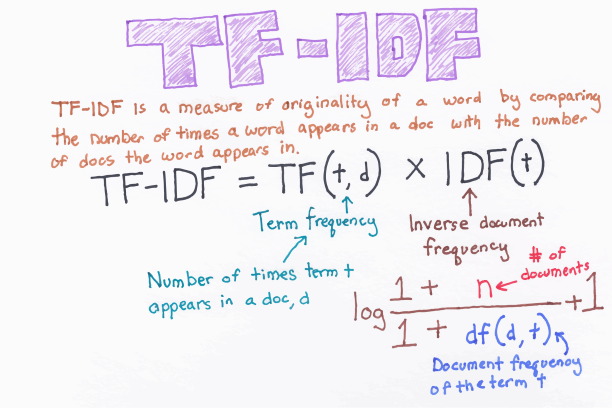

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()

tfidf_transformer.fit(x_train_dtm)
x_train_tfidf = tfidf_transformer.transform(x_train_dtm)

x_train_tfidf

<4179x5684 sparse matrix of type '<class 'numpy.float64'>'
	with 32201 stored elements in Compressed Sparse Row format>

* the "x_train_tfidf" will contain the TF-IDF **weighted representation** of the training set, which can be used as input features for training models.

## ***5.3 Word Embeddings: GloVe***

In [ ]:
texts = df['message_clean']
target = df['target_encoded']

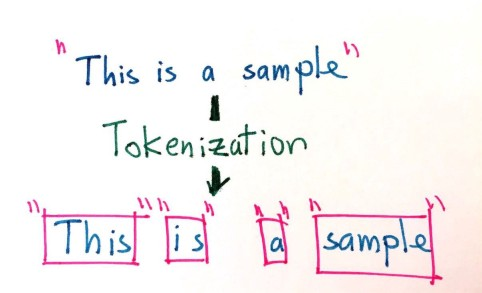

We will tokenize our text data and convert each word to its corresponding word vector using the loaded GloVe embeddings.
* & We will use these word vectors as input features for our deep learning model.

In [ ]:
# Calculate the length of our vocabulary
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(texts)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

6726

* Pad_sequences

In [ ]:
sequences = [
    [1, 2, 3],
    [4, 5],
    [6, 7, 8, 9]
]

In [ ]:
tf.keras.preprocessing.sequence.pad_sequences(
    sequences, maxlen=None, dtype='int32', padding='pre',
    truncating='pre', value=0.0
)

array([[0, 1, 2, 3],
       [0, 0, 4, 5],
       [6, 7, 8, 9]], dtype=int32)

In [ ]:
def embed(corpus):
    return word_tokenizer.texts_to_sequences(corpus) # takes a list of text data (corpus) as input and converts it into sequences of tokens

longest_train = max(texts, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

train_padded_sentences = pad_sequences(
    embed(texts),
    length_long_sentence,
    padding='post'
)

train_padded_sentences

array([[   2, 3179,  274, ...,    0,    0,    0],
       [   8,  236,  527, ...,    0,    0,    0],
       [   9,  356,  588, ...,    0,    0,    0],
       ...,
       [6724, 1002, 6725, ...,    0,    0,    0],
       [ 138, 1251, 1603, ...,    0,    0,    0],
       [1986,  378,  170, ...,    0,    0,    0]], dtype=int32)

### ***GloVe***

* GloVe method is built on an important idea,

You can derive semantic relationships between words from the co-occurrence matrix.

* To obtain a vector representation for words we can use an unsupervised learning algorithm called GloVe (Global Vectors for Word Representation), which focuses on words co-occurrences over the whole corpus. Its embeddings relate to the probabilities that two words appear together.

* Word embeddings are basically a form of word representation that bridges the human understanding of language to that of a machine. They have learned representations of text in an n-dimensional space where words that have the same meaning have a similar representation. **Meaning that two similar words are represented by almost similar vectors that are very closely placed in a vector space.**

Thus when using word embeddings, all individual words are represented as real-valued vectors in a predefined vector space. Each word is mapped to one vector and the vector values are learned in a way that resembles a neural network

In [ ]:
embeddings_dictionary = dict()
embedding_dim = 100

# Load GloVe 100D embeddings
with open('/content/drive/MyDrive/PFE/glove.6B.100d.txt') as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions

# embeddings_dictionary

* The similarity metrics used for nearest neighbor evaluations produce a single scalar that quantifies the relatedness of two words. This simplicity can be problematic since two given words almost always exhibit more intricate relationships than can be captured by a single number. For example, man may be regarded as similar to woman in that both words describe human beings; on the other hand, the two words are often considered opposites since they highlight a primary axis along which humans differ from one another.


* In order to capture in a quantitative way the nuance necessary to distinguish man from woman, it is necessary for a model to associate more than a single number to the word pair. A natural and simple candidate for an enlarged set of discriminative numbers is the vector difference between the two word vectors. GloVe is designed in order that such vector differences capture as much as possible the meaning specified by the juxtaposition of two words.

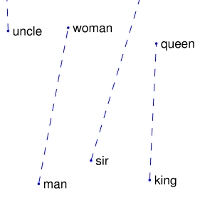

* The underlying concept that distinguishes man from woman, i.e. sex or gender, may be equivalently specified by various other word pairs, such as king and queen or brother and sister. To state this observation mathematically, we might expect that the vector differences man - woman, king - queen, and brother - sister might all be roughly equal. This property and other interesting patterns can be observed in the above set of visualizations.

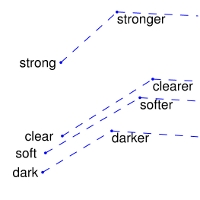

In [ ]:
# Now we will load embedding vectors of those words that appear in the
# Glove dictionary. Others will be initialized to 0.

embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.57832998, -0.0036551 ,  0.34658   , ...,  0.070204  ,
         0.44509   ,  0.24147999],
       [-0.078894  ,  0.46160001,  0.57779002, ...,  0.26352   ,
         0.59397   ,  0.26741001],
       ...,
       [ 0.63009   , -0.036992  ,  0.24052   , ...,  0.10029   ,
         0.056822  ,  0.25018999],
       [-0.12002   , -1.23870003, -0.23303001, ...,  0.13658001,
        -0.61848003,  0.049843  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

The output we obtained appears to be an array representing word embeddings obtained from GloVe (Global Vectors for Word Representation). Let's break down what this array represents:

Each row in the array corresponds to a word in our vocabulary.
The columns represent the dimensions of the word embeddings. Each value in a row represents the embedding value of the word in a particular dimension.
Here's a more detailed explanation:

* Word Embedding Dimensionality: Each word in the vocabulary is represented as a dense vector in a high-dimensional space. The number of dimensions is determined by the chosen GloVe model. For example, if you're using a GloVe model trained with 100-dimensional vectors, each word will be represented as a vector with 100 values.

* Embedding Values: The values in each row represent the embedding values for the corresponding word. These values capture the semantic meaning of the word in the context of the training corpus. Words with similar meanings or usage patterns are expected to have similar embedding values.

Example: For instance, consider the word "dog" in the vocabulary. Its embedding vector might look like [0.5, -0.3, 0.8, ...], where each value represents its position along a particular dimension in the embedding space. Similarly, the word "cat" would have its own embedding vector, which might look different but would capture its semantic similarity to "dog".

* Special Tokens: The array might also include special tokens for padding, unknown words, or other purposes. These tokens typically have embedding vectors as well.

In summary, the array contains word embeddings obtained from GloVe, where each row represents a word in the vocabulary and each column represents a dimension of the embedding space. These embeddings can be used as features in various natural language processing tasks, such as text classification or sentiment analysis.










---



---

# ***MODELING***


---



# ***6. Machine Learning Models***

In [ ]:
import plotly.figure_factory as ff

x_axes = ['Ham', 'Spam']
y_axes =  ['Spam', 'Ham']

def conf_matrix(z, x=x_axes, y=y_axes):

    z = np.flip(z, 0)

    # change each element of z to type string for annotations
    z_text = [[str(y) for y in x] for x in z]

    # set up figure
    fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

    # add title
    fig.update_layout(title_text='<b>Confusion matrix</b>',
                      xaxis = dict(title='Predicted value'),
                      yaxis = dict(title='Real value')
                     )

    # add colorbar
    fig['data'][0]['showscale'] = True

    return fig

In [ ]:
# Create a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

# Train the model
nb.fit(x_train_dtm, y_train)

MultinomialNB()



---

###*HOW NAIVE BAYES WORKS ON THIS DATA* ✅

➡ P(S) = P('You') P('have') P('won') P('a') P('lottery')  __ 1

 ➡P(S|Spam) = P('You'|Spam) P('have'|Spam) P('won'|Spam) P('a'|Spam) P('lottery'|Spam)  __ 2

Same calculation for ➡ P(S|Not_Spam) __ 3

If 2 > 3, then 'Spam' Else, 'Not_Spam'.

####*WHAT IF THE PROBABILITY IS ZERO* ❗

▶ Here comes the concept of Laplace Smoothing, where
P(words) = (word_count + 1)/(total_no_of_words + no_of_unique_words)

Here, we'll work on the existing Multinomial Naive Bayes classifier (under scikit-learn). To further understand how well Naive Bayes works for text-classification, we'll use another standard classifier, SVC...

## ***6.1 Naive Bayes DTM***

In statistics, naive Bayes classifiers are a family of simple "probabilistic classifiers" based on applying Bayes' theorem with strong (naïve) independence assumptions between the features. They are among the simplest Bayesian network models, but coupled with kernel density estimation, they can achieve higher accuracy levels.

* Naïve Bayes classifiers are highly scalable, requiring a number of parameters linear in the number of variables (features/predictors) in a learning problem. Maximum-likelihood training can be done by evaluating a closed-form expression, which takes linear time, rather than by expensive iterative approximation as used for many other types of classifiers.

In [ ]:
# Make class anf probability predictions
y_pred_class = nb.predict(x_test_dtm)
y_pred_prob = nb.predict_proba(x_test_dtm)[:, 1]
# calculate accuracy of class predictions

In [ ]:
# calculate accuracy of class predictions
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

conf_matrix(metrics.confusion_matrix(y_test, y_pred_class))

0.9784637473079684


Le score AUC est une mesure de performance pour les problèmes de classification binaire, comme la détection de spam. Il résume la capacité du modèle à distinguer correctement les classes positives et négatives dans un seul nombre compris entre 0 et 1.

* ROC AUC score: Area Under the Receiver Operating Characteristic Curve score

In [ ]:
# Calculate AUC
metrics.roc_auc_score(y_test, y_pred_prob)

0.974296765425861

## ***6.2 Naive Bayes***

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

pipe = Pipeline([('bow', CountVectorizer()),
                 ('tfid', TfidfTransformer()),
                 ('model', MultinomialNB())])

In [ ]:
# Fit the pipeline with the data
pipe.fit(x_train, y_train)

y_pred_class = pipe.predict(x_test)

print(metrics.accuracy_score(y_test, y_pred_class))

conf_matrix(metrics.confusion_matrix(y_test, y_pred_class))

0.9597989949748744


## ***6.3 XGBoost***

In [ ]:
import xgboost as xgb

pipe = Pipeline([
    ('bow', CountVectorizer()),
    ('tfid', TfidfTransformer()),
    ('model', xgb.XGBClassifier(
        learning_rate=0.1,
        max_depth=7,
        n_estimators=80,
        use_label_encoder=False,
        eval_metric='auc',
        # colsample_bytree=0.8,
        # subsample=0.7,
        # min_child_weight=5,
    ))
])

In [ ]:
# Fit the pipeline with the data
pipe.fit(x_train, y_train)

y_pred_class = pipe.predict(x_test)
y_pred_train = pipe.predict(x_train)

print('Train: {}'.format(metrics.accuracy_score(y_train, y_pred_train)))
print('Test: {}'.format(metrics.accuracy_score(y_test, y_pred_class)))


conf_matrix(metrics.confusion_matrix(y_test, y_pred_class))

Train: 0.9830102895429529
Test: 0.9641062455132807




*   ***Visualization***



In [ ]:
model_name = ['Accuracy', 'AUC', 'Recall Score & F1 Score']
accuracy_list = [metrics.accuracy_score(y_test, y_pred_class)]
auc_list = [metrics.roc_auc_score(y_test, y_pred_prob)]
recall_list = [metrics.recall_score(y_test, y_pred_class)]
f1_list = [metrics.f1_score(y_test, y_pred_class)]
def plot_model_score(model_name, accuracy_list, auc_list, recall_list, f1_list, title):

    fig = go.Figure(data=[
        go.Bar(name='Accuracy', x=model_name, y=np.round(accuracy_list,3), text=np.round(accuracy_list,3), marker_color='#97bad9'),
        go.Bar(name='AUC',x=model_name, y=np.round(auc_list,3), text=np.round(auc_list,3), marker_color= '#bcd6ef'),
        go.Bar(name='Recall',   x=model_name, y=np.round(recall_list,3), text=np.round(recall_list,3), marker_color='#ebcad9'),
        go.Bar(name='F1',       x=model_name, y=np.round(f1_list,3), text=np.round(f1_list,3), marker_color='#d5a6bd')
    ])

    fig.update_layout(template = 'simple_white', title = title)
    fig.update_layout(xaxis_title="Models", yaxis_title="Score", font = dict(size=17, family = 'Franklin Gothic'))
    fig.update_layout(yaxis_range=[0.7,1])

    fig.show()

In [ ]:
plot_model_score(model_name, accuracy_list, auc_list, recall_list, f1_list,
                 'Accuracy, AUC, Recall Score & F1 Score')

# ***7. CNN***

In [ ]:
from keras.utils import to_categorical
from keras.preprocessing import sequence, text
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Conv1D, GlobalMaxPooling1D, Dropout, Dense, Input, Embedding, MaxPooling1D, Flatten
from keras.callbacks import ModelCheckpoint


MAX_WORDS_IN_SEQ = 1000
EMBED_DIM = 100
MODEL_NAME = "/content/drive/MyDrive/PFE/cnn_model"

In [ ]:
df.head()

,target,message,message_len,message_clean,target_encoded
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazi avail bugi n great world...,0
1,ham,Ok lar... Joking wif u oni...,6,ok lar joke wif oni,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entri wkli comp win fa cup final tkts m...,1
3,ham,U dun say so early hor... U c already then say...,11,dun say ear hor alreadi say,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goe usf live around though,0


In [ ]:
emails = df['message_clean']
labels = [1 if x == "spam" else 0 for x in df['target'].values]

In [ ]:
max_len = max(map(lambda x: len(x), emails))
max_len

476

In [ ]:
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(emails)
sequences = tokenizer.texts_to_sequences(emails)
word2index = tokenizer.word_index
num_words = len(word2index)
print(f"Found {num_words} unique tokens")

Found 6725 unique tokens


In [ ]:
# Apply padding/truncating to sequences
data = sequence.pad_sequences(sequences, maxlen=MAX_WORDS_IN_SEQ, padding='post', truncating='post')

# Convert labels to categorical AFTER splitting data
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)

# Convert labels to categorical
y_train_categorical = to_categorical(y_train, num_classes=2)
y_test_categorical = to_categorical(y_test, num_classes=2)

print('Shape of training data tensor:', x_train.shape)
print('Shape of testing data tensor:', x_test.shape)
print('Shape of training label tensor:', y_train_categorical.shape)
print('Shape of testing label tensor:', y_test_categorical.shape)


Shape of training data tensor: (4457, 1000)
Shape of testing data tensor: (1115, 1000)
Shape of training label tensor: (4457, 2)
Shape of testing label tensor: (1115, 2)


In [ ]:
data = sequence.pad_sequences(sequences, maxlen=MAX_WORDS_IN_SEQ, padding='post', truncating='post')
#print(labels[:10])
#labels = to_categorical(labels)
labels = to_categorical(labels, num_classes=2)
print(labels[:10])

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)

[[1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]
Shape of data tensor: (5572, 1000)
Shape of label tensor: (5572, 2)


In [ ]:
input_seq = Input(shape=[MAX_WORDS_IN_SEQ, ], dtype='int32')
# Add 1 to num_words to account for the index starting from 1
embed_seq = Embedding(num_words + 1, EMBED_DIM, embeddings_initializer='glorot_uniform', input_length=MAX_WORDS_IN_SEQ)(
    input_seq)

conv_1 = Conv1D(128, 5, activation='relu')(embed_seq)
conv_1 = MaxPooling1D(pool_size=5)(conv_1)
conv_2 = Conv1D(128, 5, activation='relu')(conv_1)
conv_2 = MaxPooling1D(pool_size=5)(conv_2)
conv_3 = Conv1D(128, 5, activation='relu')(conv_2)
conv_3 = MaxPooling1D(pool_size=35)(conv_3)
flat = Flatten()(conv_3)
# flat = Dropout(0.25)(flat)
fc1 = Dense(128, activation='relu')(flat)
# dense_1 = Dropout(0.25)(flat)
fc2 = Dense(2, activation='softmax')(fc1)

model = Model(input_seq, fc2)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
# Testing ---------------------------------------
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000)]            0         
                                                                 
 embedding (Embedding)       (None, 1000, 100)         672600    
                                                                 
 conv1d (Conv1D)             (None, 996, 128)          64128     
                                                                 
 max_pooling1d (MaxPooling1  (None, 199, 128)          0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 195, 128)          82048     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 39, 128)           0         
 g1D)                                                        

In [ ]:
# Train the model
history = model.fit(
    x_train, y_train,
    epochs=5,
    batch_size=64,
    validation_split=0.1  # We use a portion of the training data for validation
)

Epoch 1/5
63/63 [==============================] - 82s 1s/step - loss: 0.4035 - acc: 0.8484 - val_loss: 0.1892 - val_acc: 0.8901
Epoch 2/5
63/63 [==============================] - 60s 959ms/step - loss: 0.1100 - acc: 0.9531 - val_loss: 0.0623 - val_acc: 0.9843
Epoch 3/5
63/63 [==============================] - 85s 1s/step - loss: 0.0156 - acc: 0.9943 - val_loss: 0.0688 - val_acc: 0.9798
Epoch 4/5
63/63 [==============================] - 60s 941ms/step - loss: 0.0063 - acc: 0.9985 - val_loss: 0.0812 - val_acc: 0.9821
Epoch 5/5
63/63 [==============================] - 62s 995ms/step - loss: 0.0034 - acc: 0.9993 - val_loss: 0.0967 - val_acc: 0.9798


* The loss decreases and the accuracy increases with each epoch, indicating that the model is learning and improving over time.
*Both training and validation accuracies are high, indicating that the model is performing well on both the training and validation datasets.
* There's a slight fluctuation in the validation loss and accuracy between epochs, which is normal during the training process.
*The model achieves high accuracy on the validation set, which suggests that it generalizes well to unseen data.

## ***7.1 Evaluation metrics***

In [ ]:
from sklearn.metrics import classification_report

# Predict labels for test data
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)  # Convert softmax probabilities to class labels

# Convert one-hot encoded labels to integers
y_true = np.argmax(y_test, axis=1)

# Calculate evaluation metrics
report = classification_report(y_true, y_pred, target_names=['ham', 'spam'])
print(report)


35/35 [==============================] - 4s 107ms/step
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       973
        spam       0.97      0.87      0.92       142

    accuracy                           0.98      1115
   macro avg       0.98      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115



**Precision:**  The ratio of true positive predictions to the total number of positive predictions made by the model.

* For the 'ham' class, the precision is 98%, meaning that 98% of the emails predicted as 'ham' by the model were actually 'ham'.

* For the 'spam' class, the precision is 95%, indicating that 95% of the emails predicted as 'spam' by the model were actually 'spam'.

**Recall:** The ratio of true positive predictions to the total number of actual positive instances in the data.

* For the 'ham' class, the recall is 99%, indicating that 99% of the actual 'ham' emails were correctly identified by the model.

* For the 'spam' class, the recall is 90%, meaning that 90% of the actual 'spam' emails were correctly identified by the model.

**F1-score:** The harmonic mean of precision and recall, providing a balance between the two metrics. It ranges from 0 to 1, where higher values indicate better performance. For the 'ham' class, the F1-score is 0.99, and for the 'spam' class, the F1-score is 0.93.


## ***7.2 Visualization***

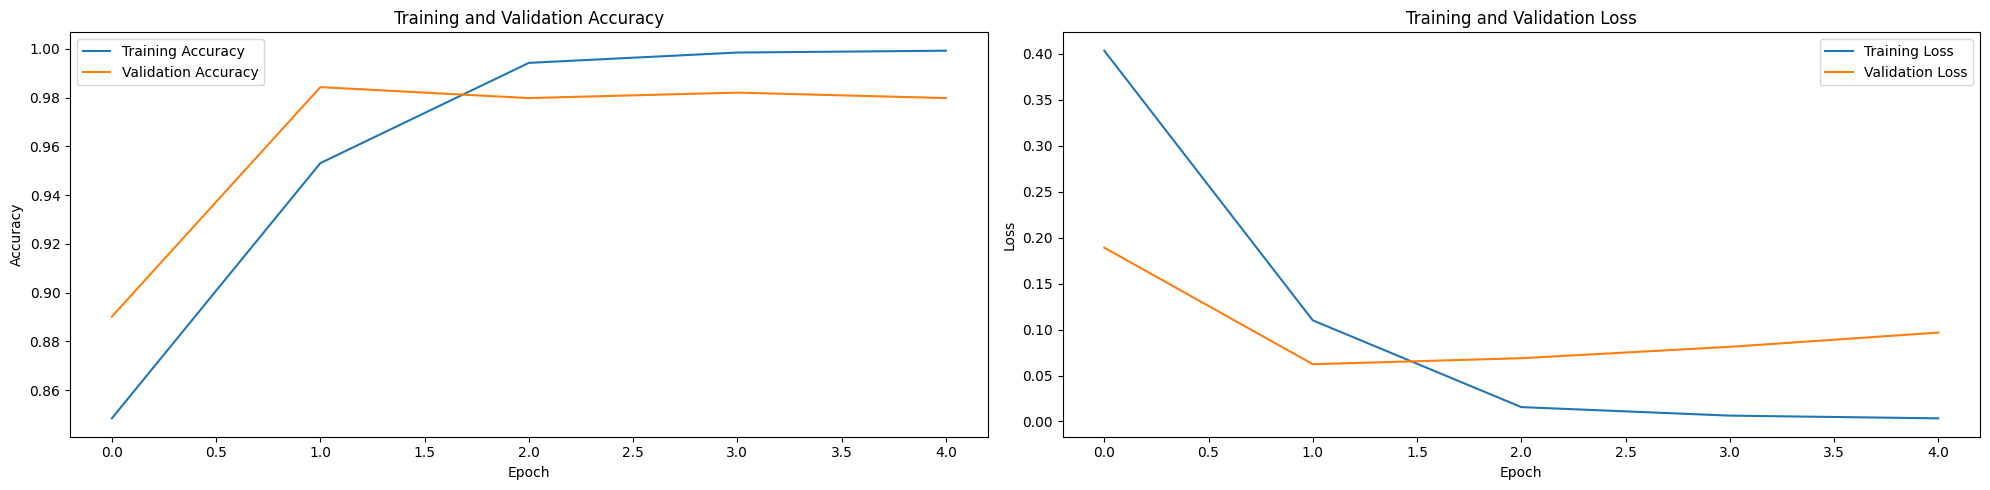

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(20,5))

# Plot training and validation accuracy
axes[0].plot(history.history['acc'], label='Training Accuracy')
axes[0].plot(history.history['val_acc'], label='Validation Accuracy')
axes[0].set_title('Training and Validation Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Plot training and validation loss
axes[1].plot(history.history['loss'], label='Training Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Training and Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

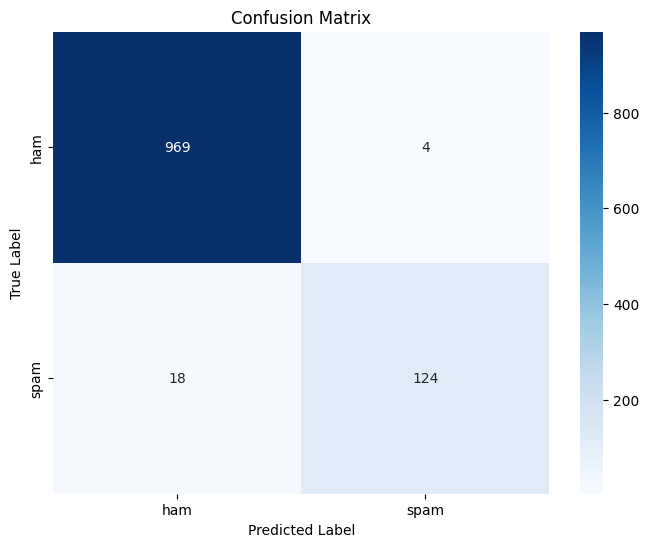

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ***8. LSTM***

## ***8.1  Building the Model***


* By splitting the data into training and testing sets, we ensure that the model is trained on one subset of the data and evaluated on another, separate subset. This allows us to assess the model's generalization performance on unseen data. The split ratio (in this case, 75% training and 25% testing) is a common choice.

In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    train_padded_sentences,
    target,
    test_size=0.25
)

* Import the libraries needed in the Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GlobalMaxPool1D, BatchNormalization, Dropout, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau


In [ ]:
def glove_lstm():
    model = Sequential()

    model.add(Embedding( #converts integer indices into dense vectors
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_matrix.shape[1],
        weights = [embedding_matrix],
        input_length=length_long_sentence
    ))

    model.add(Bidirectional(LSTM(
        length_long_sentence,
        return_sequences = True,
        recurrent_dropout=0.2
    )))

    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

    return model

model = glove_lstm()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 80, 100)           672600    
                                                                 
 bidirectional (Bidirection  (None, 80, 160)           115840    
 al)                                                             
                                                                 
 global_max_pooling1d (Glob  (None, 160)               0         
 alMaxPooling1D)                                                 
                                                                 
 batch_normalization (Batch  (None, 160)               640       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                        

In [ ]:
# Load the model and train!!

model = glove_lstm()

checkpoint = ModelCheckpoint(
    'model.h5',
    monitor = 'val_loss',
    verbose = 1,
    save_best_only = True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2,
    verbose = 1,
    patience = 5,
    min_lr = 0.001
)
history = model.fit(
    X_train,
    y_train,
    epochs = 7,
    batch_size = 32,
    validation_data = (X_test, y_test),
    verbose = 1,
    callbacks = [reduce_lr, checkpoint]
)

Epoch 1/7
131/131 [==============================] - ETA: 0s - loss: 0.3292 - accuracy: 0.8772
Epoch 1: val_loss improved from inf to 0.36163, saving model to model.h5
131/131 [==============================] - 52s 339ms/step - loss: 0.3292 - accuracy: 0.8772 - val_loss: 0.3616 - val_accuracy: 0.9576 - lr: 0.0010
Epoch 2/7


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



131/131 [==============================] - ETA: 0s - loss: 0.1751 - accuracy: 0.9419
Epoch 2: val_loss improved from 0.36163 to 0.15853, saving model to model.h5
131/131 [==============================] - 41s 311ms/step - loss: 0.1751 - accuracy: 0.9419 - val_loss: 0.1585 - val_accuracy: 0.9684 - lr: 0.0010
Epoch 3/7
131/131 [==============================] - ETA: 0s - loss: 0.1350 - accuracy: 0.9538
Epoch 3: val_loss improved from 0.15853 to 0.10679, saving model to model.h5
131/131 [==============================] - 43s 330ms/step - loss: 0.1350 - accuracy: 0.9538 - val_loss: 0.1068 - val_accuracy: 0.9706 - lr: 0.0010
Epoch 4/7
131/131 [==============================] - ETA: 0s - loss: 0.1042 - accuracy: 0.9696
Epoch 4: val_loss improved from 0.10679 to 0.09854, saving model to model.h5
131/131 [==============================] - 45s 341ms/step - loss: 0.1042 - accuracy: 0.9696 - val_loss: 0.0985 - val_accuracy: 0.9756 - lr: 0.0010
Epoch 5/7
131/131 [==============================] - 

The output shows the training and validation loss and accuracy of the model over 7 epochs.

* *The training loss decreases from 0.30 to 0.06 over the 7 epochs, which indicates that the model is learning to fit the training data better.*

* ***The validation loss also decreases from 0.41 to 0.07, which indicates that the model is generalizing well to unseen data.***

* *The training accuracy **increases** from 0.89 to 0.98, which indicates that the model is correctly classifying more and more training examples.*

* ***The validation accuracy also increases from 0.96 to 0.98, which indicates that the model is generalizing well to unseen data.***

Overall, the output shows that the LSTM model is training well and generalizing well to unseen data.




## ***8.2 Visualization of the Model***


Let's visualize the training and validation curves of metrics such as loss and accuracy over epochs. It helps to analyze the model's performance and identify potential issues such as overfitting or underfitting.











In [ ]:
def plot_learning_curves(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

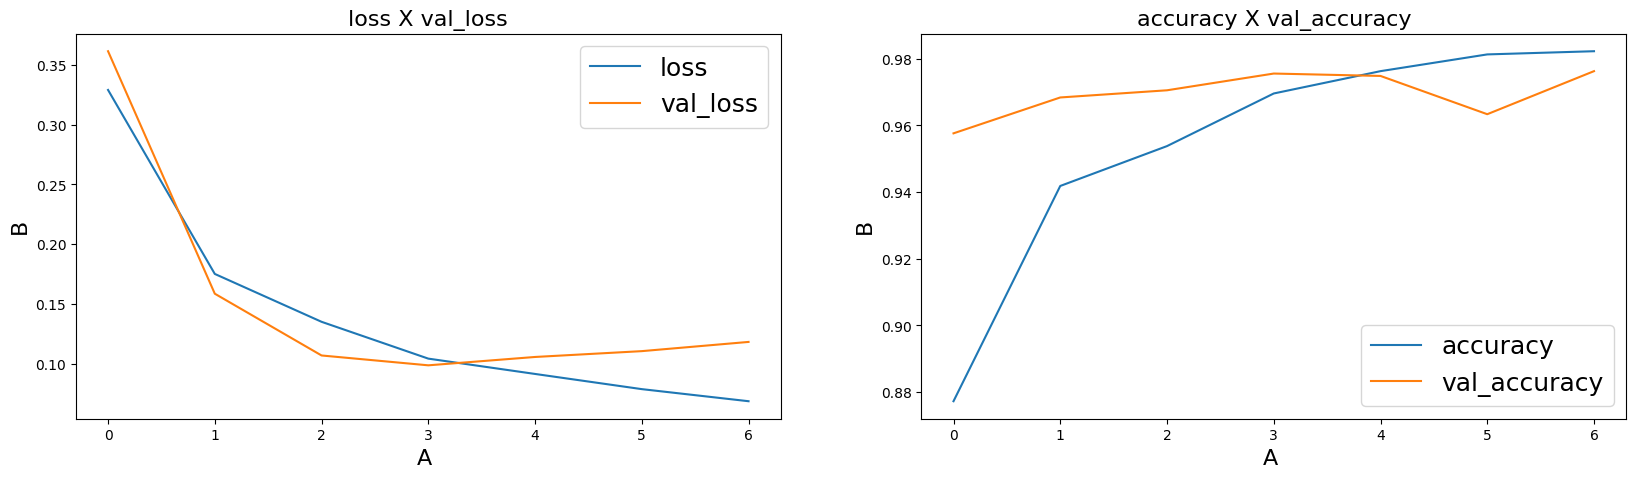

In [ ]:
plot_learning_curves(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

  This two graphs compare the training and validation loss and accuracy of an LSTM model over 7 epochs.

* The left graph shows the **loss** (training loss and validation loss)

* The right graph shows the **accuracy** (training accuracy and validation accuracy)

On both ***graphs***, the **x-axis** represents ***the epoch number***, and the **y-axis** represents the loss or accuracy **value**.


                                         Loss:
* The training loss (blue line) starts high and steadily decreases over the epochs, reaching its lowest point at epoch 7.
This indicates that the model **is learning to fit the training data better** as the training progresses.
* The validation loss (orange line) also decreases over the epochs, but it fluctuates a little more than the training loss. This suggests that the **model is generalizing well to unseen data**.


---


                                      Accuracy:
* The training accuracy (green line) starts moderately high and increases slightly over the epochs.
* The validation accuracy (purple line) also increases over the epochs, and it is consistently higher than the training accuracy.
* This indicates that the **model is performing well on both the training data and the validation data.**

Overall, the plots show that the LSTM model is training well and generalizing well to unseen data.

44/44 [==============================] - 3s 47ms/step


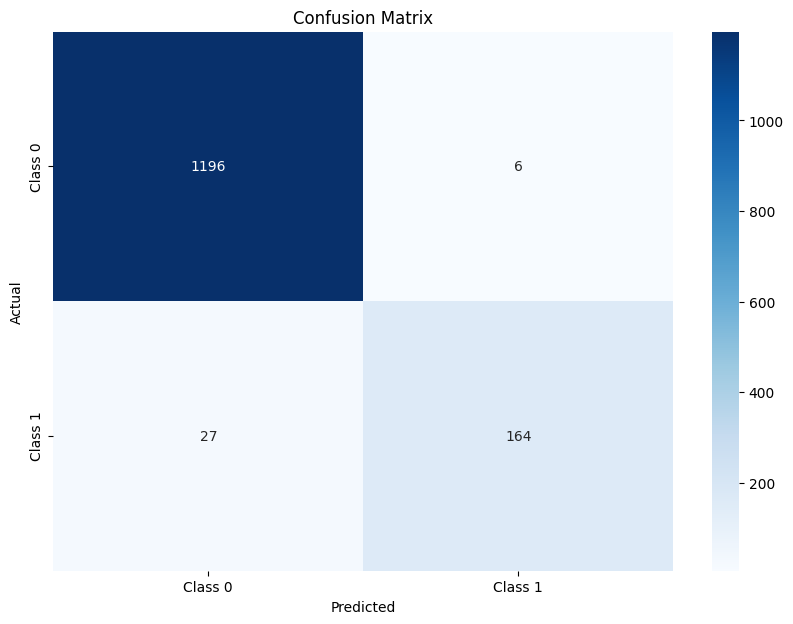

In [ ]:
# Define the function to plot the confusion matrix
def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

# Generate predictions
y_preds = (model.predict(X_test) > 0.5).astype("int32")

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_preds)

# Define class names
class_names = ['Class 0', 'Class 1']

# Plot the confusion matrix
plot_confusion_matrix(conf_matrix, class_names)
#y_preds = (model.predict(X_test) > 0.5).astype("int32")
#conf_matrix(metrics.confusion_matrix(y_test, y_preds))



The confusion matrix above shows the performance of the LSTM model on classifying emails as spam or not spam.

* ***Ham 1198:*** ***correctly classified emails as ham*** (True Negative)

* **7:**  emails **incorrectly classified as spam** (False Positive)

* **Spam 18:** emails **incorrectly classified as ham** (False Negative)
* **170:** ***correctly classified emails as spam*** (True Positive)


 In this case, the model seems to be performing well with a high number of correctly classified emails (TP and TN) and a relatively low number of incorrectly classified emails (FP and FN).


# ***9. HAN***





* ##    **Han with CountVectorizer**


In [ ]:
# Define X and y
x = df['message_clean']
y = df['target_encoded']

# Split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

# Instantiate the vectorizer
vect = CountVectorizer()
vect.fit(x_train)

# Transform text data into document-term matrices
x_train_dtm = vect.transform(x_train)
x_test_dtm = vect.transform(x_test)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Bidirectional, GRU, Dense, TimeDistributed, Flatten, Activation, RepeatVector, Permute, concatenate
from tensorflow.keras.models import Model
from sklearn.feature_extraction.text import CountVectorizer

# Convert to dense arrays
x_train_dense = x_train_dtm.toarray()
x_test_dense = x_test_dtm.toarray()

VOCAB_SIZE = len(vect.vocabulary_)
MAX_SENTENCE_LENGTH = x_train_dtm.shape[1]  # Number of features (words) in the CountVectorizer
MAX_SENTENCES = 1  # Assuming each document is considered as a single sentence for this context

# Define the input layers
sentence_input = Input(shape=(MAX_SENTENCE_LENGTH,), dtype='int32')
document_input = Input(shape=(MAX_SENTENCES, MAX_SENTENCE_LENGTH), dtype='int32')

# Define sentence-level GRU layer
sentence_gru = Bidirectional(GRU(units=50, return_sequences=True))(tf.cast(tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=100)(sentence_input), dtype=tf.float32))

# Define attention layer for sentences
sentence_attention = TimeDistributed(Dense(1, activation='tanh'))(sentence_gru)
sentence_attention = Flatten()(sentence_attention)
sentence_attention = Activation('softmax')(sentence_attention)
sentence_attention = RepeatVector(100)(sentence_attention)
sentence_attention = Permute([2, 1])(sentence_attention)

# Apply attention to the sentence GRU output
sentence_representation = tf.keras.layers.multiply([sentence_gru, sentence_attention])
sentence_representation = tf.keras.layers.Lambda(lambda xin: tf.keras.backend.sum(xin, axis=-2), output_shape=(100,))(sentence_representation)

# Define document-level GRU layer
document_gru = Bidirectional(GRU(units=50, return_sequences=True))(tf.cast(document_input, dtype=tf.float32))

# Define attention layer for documents
document_attention = TimeDistributed(Dense(1, activation='tanh'))(document_gru)
document_attention = Flatten()(document_attention)
document_attention = Activation('softmax')(document_attention)
document_attention = RepeatVector(100)(document_attention)
document_attention = Permute([2, 1])(document_attention)

# Apply attention to the document GRU output
document_representation = tf.keras.layers.multiply([document_gru, document_attention])
document_representation = tf.keras.layers.Lambda(lambda xin: tf.keras.backend.sum(xin, axis=-2), output_shape=(100,))(document_representation)

# Concatenate sentence and document representations
merged_representation = concatenate([sentence_representation, document_representation])

# Define output layer
output = Dense(1, activation='sigmoid')(merged_representation)

# Define the model
model = Model(inputs=[sentence_input, document_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 5684)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 5684, 100)            568400    ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, 1, 5684)]            0         []                            
                                                                                                  
 tf.cast (TFOpLambda)        (None, 5684, 100)            0         ['embedding[0][0]']           
                                                                                              

In [ ]:
# Reshape x_train and x_test to fit the model's input shape
x_train_reshaped = np.reshape(x_train_dtm.toarray(), (len(x_train), MAX_SENTENCES, MAX_SENTENCE_LENGTH))
x_test_reshaped = np.reshape(x_test_dtm.toarray(), (len(x_test), MAX_SENTENCES, MAX_SENTENCE_LENGTH))

# Train the model
history = model.fit([x_train_dtm.toarray(), x_train_reshaped], y_train, epochs=5, batch_size=32, validation_data=([x_test_dtm.toarray(), x_test_reshaped], y_test))


Epoch 1/5
131/131 [==============================] - 2127s 16s/step - loss: 0.2478 - accuracy: 0.9158 - val_loss: 0.1046 - val_accuracy: 0.9663
Epoch 2/5
131/131 [==============================] - 2046s 16s/step - loss: 0.0564 - accuracy: 0.9828 - val_loss: 0.0739 - val_accuracy: 0.9777
Epoch 3/5
131/131 [==============================] - 1993s 15s/step - loss: 0.0253 - accuracy: 0.9928 - val_loss: 0.0693 - val_accuracy: 0.9806
Epoch 4/5
131/131 [==============================] - 2015s 15s/step - loss: 0.0135 - accuracy: 0.9966 - val_loss: 0.0699 - val_accuracy: 0.9828
Epoch 5/5
131/131 [==============================] - 1968s 15s/step - loss: 0.0080 - accuracy: 0.9983 - val_loss: 0.0788 - val_accuracy: 0.9821


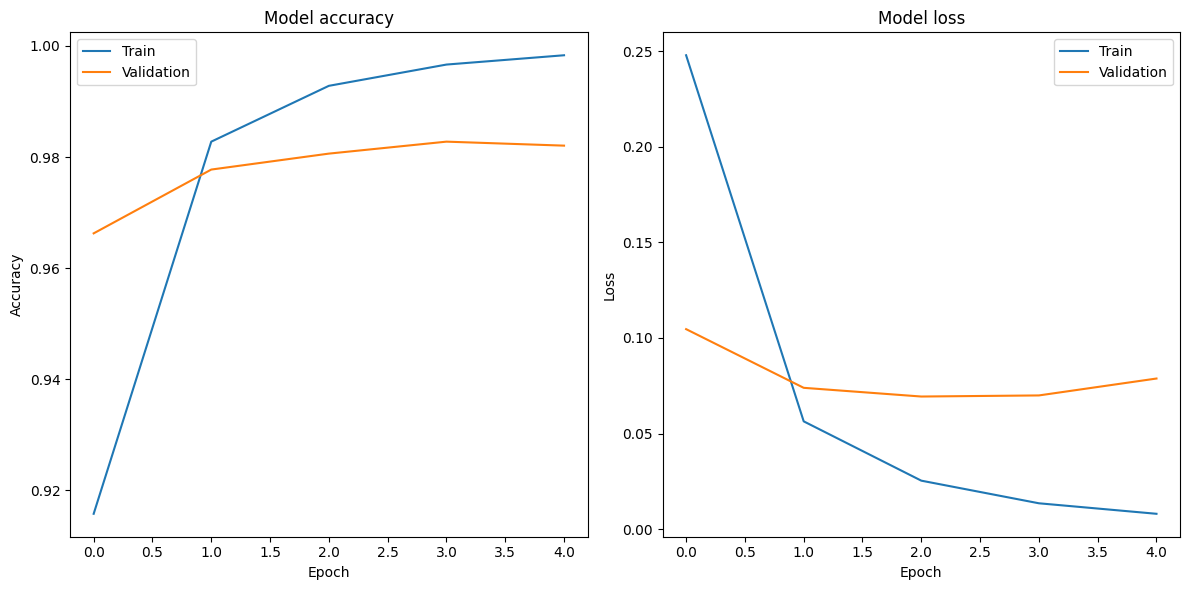

In [ ]:
# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



* ##    **Han with TF-IDF**


In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from tensorflow.keras.layers import Input, Bidirectional, GRU, Dense, TimeDistributed, Flatten, Activation, RepeatVector, Permute, concatenate
from tensorflow.keras.models import Model

# Transform using TF-IDF
tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(x_train_dtm)
x_train_tfidf = tfidf_transformer.transform(x_train_dtm)
x_test_tfidf = tfidf_transformer.transform(x_test_dtm)

# Convert TF-IDF matrices to dense arrays
x_train_dense = x_train_tfidf.toarray()
x_test_dense = x_test_tfidf.toarray()

#Define maximum sentence length based on the TF-IDF transformed data
MAX_SENTENCE_LENGTH = x_train_tfidf.shape[1]
MAX_SENTENCES = 1 # Assuming each document is considered as a single sentence for this context

#Reshape to match the model's input shape
x_train_reshaped = np.reshape(x_train_dense, (len(x_train), MAX_SENTENCES, MAX_SENTENCE_LENGTH))
x_test_reshaped = np.reshape(x_test_dense, (len(x_test), MAX_SENTENCES, MAX_SENTENCE_LENGTH))

#Vocabulary size from the CountVectorizer
VOCAB_SIZE = len(vect.vocabulary_)

#Define input layers
sentence_input = Input(shape=(MAX_SENTENCE_LENGTH,), dtype='float32')
document_input = Input(shape=(MAX_SENTENCES, MAX_SENTENCE_LENGTH), dtype='float32')

#Define sentence-level GRU layer
sentence_gru = Bidirectional(GRU(units=50, return_sequences=True))(tf.keras.layers.Reshape((MAX_SENTENCE_LENGTH, 1))(sentence_input))

#Define attention layer for sentences
sentence_attention = TimeDistributed(Dense(1, activation='tanh'))(sentence_gru)
sentence_attention = Flatten()(sentence_attention)
sentence_attention = Activation('softmax')(sentence_attention)
sentence_attention = RepeatVector(100)(sentence_attention)
sentence_attention = Permute([2, 1])(sentence_attention)

#Apply attention to the sentence GRU output
sentence_representation = tf.keras.layers.multiply([sentence_gru, sentence_attention])
sentence_representation = tf.keras.layers.Lambda(lambda xin: tf.keras.backend.sum(xin, axis=-2), output_shape=(100,))(sentence_representation)

#Define document-level GRU layer
document_gru = Bidirectional(GRU(units=50, return_sequences=True))(tf.keras.layers.Reshape((MAX_SENTENCES, MAX_SENTENCE_LENGTH))(document_input))

#Define attention layer for documents
document_attention = TimeDistributed(Dense(1, activation='tanh'))(document_gru)
document_attention = Flatten()(document_attention)
document_attention = Activation('softmax')(document_attention)
document_attention = RepeatVector(100)(document_attention)
document_attention = Permute([2, 1])(document_attention)

#Apply attention to the document GRU output
document_representation = tf.keras.layers.multiply([document_gru, document_attention])
document_representation = tf.keras.layers.Lambda(lambda xin: tf.keras.backend.sum(xin, axis=-2), output_shape=(100,))(document_representation)

#Concatenate sentence and document representations
merged_representation = concatenate([sentence_representation, document_representation])

#Define output layer
output = Dense(1, activation='sigmoid')(merged_representation)

#Define the model
model = Model(inputs=[sentence_input, document_input], outputs=output)

#Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#rint the model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 5684)]               0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 1, 5684)]            0         []                            
                                                                                                  
 reshape (Reshape)           (None, 5684, 1)              0         ['input_3[0][0]']             
                                                                                                  
 reshape_1 (Reshape)         (None, 1, 5684)              0         ['input_4[0][0]']             
                                                                                            

In [ ]:
#Train the model
history = model.fit([x_train_dense, x_train_reshaped], y_train, epochs=5, batch_size=32, validation_data=([x_test_dense, x_test_reshaped], y_test))

Epoch 1/5
131/131 [==============================] - 837s 6s/step - loss: 0.3718 - accuracy: 0.8660 - val_loss: 0.2283 - val_accuracy: 0.8909
Epoch 2/5
131/131 [==============================] - 771s 6s/step - loss: 0.1269 - accuracy: 0.9584 - val_loss: 0.1020 - val_accuracy: 0.9677
Epoch 3/5
131/131 [==============================] - 767s 6s/step - loss: 0.0521 - accuracy: 0.9852 - val_loss: 0.0812 - val_accuracy: 0.9756
Epoch 4/5
131/131 [==============================] - 736s 6s/step - loss: 0.0290 - accuracy: 0.9926 - val_loss: 0.0781 - val_accuracy: 0.9763
Epoch 5/5
131/131 [==============================] - 762s 6s/step - loss: 0.0179 - accuracy: 0.9959 - val_loss: 0.0741 - val_accuracy: 0.9777
